Importação dos pacotes necessários

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
from fredapi import Fred
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
from collections import OrderedDict
from pandas.plotting import register_matplotlib_converters
from statsmodels.tsa.stattools import adfuller, kpss, bds
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import het_arch
from statsmodels.graphics.gofplots import qqplot
from scipy.stats import skewtest, kurtosistest, skew, kurtosis, boxcox
from pathlib import Path
import os
os.environ['OMP_NUM_THREADS'] = '1'

In [4]:
import optuna

Criação/carregamento do ficheiro de armazenamento de corridas de optuna

In [5]:
optuna_storage_path = "optuna_journal_storage.log"
lock_obj = optuna.storages.journal.JournalFileOpenLock(optuna_storage_path)
storage = optuna.storages.JournalStorage(
    optuna.storages.journal.JournalFileBackend(optuna_storage_path, lock_obj=lock_obj)
)

In [6]:
import logging
cmdstanpy_logger = logging.getLogger("cmdstanpy")
cmdstanpy_logger.disabled = True

# Importação do **darts**

O darts é uma biblioteca de python para timeseries, com o intuito de simplificar e agilizar o processo de análise e modelação de séries temporais.

In [7]:
from darts import TimeSeries
from darts.utils import statistics
from darts.metrics import mape
from darts.utils.utils import ModelMode, SeasonalityMode

Para aceder a séries temporais do FRED (fred.stlouisfed.org) ao vivo, utilizamos uma API Key pessoal.

In [8]:
fred = Fred(api_key="8ede227d95e33c5cdf2ea8a83577bc0a")

Séries temporais escolhidas:

In [9]:
fred_series_ids = ["IHLIDXNSAGB", "IRLTLT01GBM156N", "QGBN628BIS", "UKNGDP", "GBRCPIALLMINMEI"]

In [10]:
fred_series_metadata = []
fred_series_list = []
for series in fred_series_ids:
    metadata = fred.get_series_info(series)
    series = fred.get_series(series).rename(metadata["title"])
    fred_series_metadata.append(metadata)
    fred_series_list.append(series)

Dados extra: Incerteza com políticas económicas no Reino Unido com periodicidade diária não existe no FRED

In [11]:
economic_uncertainty = pd.read_csv("../data/UK_Daily_Policy_Data.csv")

In [12]:
economic_uncertainty["date"] = pd.to_datetime(economic_uncertainty.drop("daily_policy_index", axis=1))
economic_uncertainty = economic_uncertainty.drop(["day", "month", "year"], axis=1).set_index("date").squeeze()

In [13]:
economic_uncertainty

date
2001-01-01     50.70
2001-01-02    110.77
2001-01-03    179.41
2001-01-04    183.22
2001-01-05     89.31
               ...  
2025-04-26    287.84
2025-04-27    340.04
2025-04-28    418.48
2025-04-29    255.07
2025-04-30    367.90
Name: daily_policy_index, Length: 8886, dtype: float64

In [14]:
data = fred_series_list.copy()
data.append(economic_uncertainty)

In [15]:
# Conversão para formato time series suportado pelo darts
data_ts = [TimeSeries.from_series(series) for series in data]

In [16]:
# Teste de sazonalidade 
[statistics.check_seasonality(series, max_lag=365) for series in data_ts]

[(False, 0), (False, 0), (False, 0), (False, 0), (False, 0), (True, 7)]

# Time Series Forecasting

In [17]:
[print(str(idx) + " " + series.title) for idx, series in enumerate(fred_series_metadata)]
print(str(len(data_ts) - 1) + " " + "UK_Daily_Policy_Data")

0 Job Postings on Indeed in the United Kingdom
1 Interest Rates: Long-Term Government Bond Yields: 10-Year: Main (Including Benchmark) for United Kingdom
2 Residential Property Prices for United Kingdom
3 Gross Domestic Product for United Kingdom
4 Consumer Price Indices (CPIs, HICPs), COICOP 1999: Consumer Price Index: Total for United Kingdom
5 UK_Daily_Policy_Data


In [18]:
series_names = ["Job_Postings", "Interest_Rates", "Residential_Property_Prices", "GDP", "CPI", "Economic_Uncertainty"]

#### **Escolher série temporal para modelar**

In [19]:
series_chosen_id = 0

In [20]:
series = data_ts[series_chosen_id]
series_name = series_names[series_chosen_id]

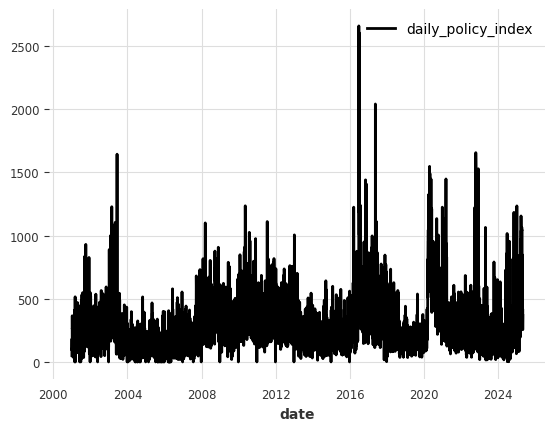

In [21]:
series.plot()
plt.show()

splitting: proporção da série usar para treino de modelos, o resto é usado para validação  
1 - visualizing: proporção da série que queremos visualizar

In [22]:
splitting = 0.95
visualizing = 0.9

In [23]:
train, val = series.split_before(splitting)

## Primeiro modelo - Error Trend Seasonality

No pacote **darts**, a família de modelos de ETS encontram-se no módulo de Exponential Smoothing, com os parâmetros _trend_  e _seasonal_.

In [25]:
from darts.models import ExponentialSmoothing

model = ExponentialSmoothing(trend=ModelMode.ADDITIVE, 
                             seasonal=SeasonalityMode.ADDITIVE)
model.fit(train)
prediction = model.predict(len(val))

In [26]:
len(series)

8886

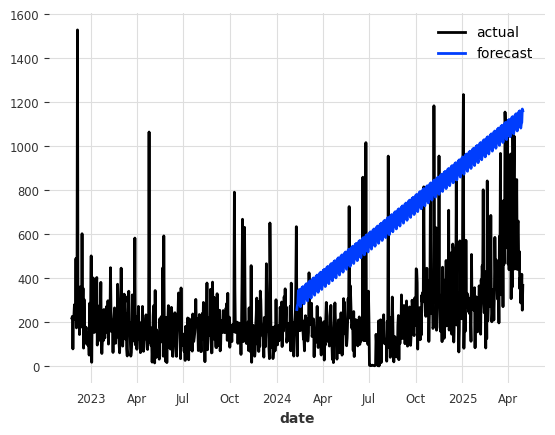

In [27]:
series.drop_before(visualizing).plot(label="actual")  # plot only last 1-visualizing of series
prediction.plot(label="forecast", low_quantile=0.05, high_quantile=0.95)
plt.legend()
plt.show()

## Segundo modelo - Família ARIMA

Neste segmento exploramos a seleção de modelos automática providenciada pelo **darts/statsforecast**.  


Critério selecionado: "BIC"

In [31]:
from darts.models import AutoARIMA

print(f"Information Criteria: {(ic:='bic')}")
model_aarima = AutoARIMA(trace=True, ic=ic, seasonal=True)
model_aarima = model_aarima.fit(train)
prediction_aarima = model_aarima.predict(len(val))

Information Criteria: bic

ARIMA(2,1,2) with drift        :106453.40700726806

ARIMA(0,1,0) with drift        :109582.72039957865

ARIMA(1,1,0) with drift        :108230.41116726371

ARIMA(0,1,1) with drift        :106720.10105131929

ARIMA(0,1,0)                   :109574.5806714427

ARIMA(1,1,2) with drift        :106444.48948146003

ARIMA(0,1,2) with drift        :106462.8594019026

ARIMA(1,1,1) with drift        :106437.63129614569

ARIMA(2,1,1) with drift        :106444.37541458978

ARIMA(2,1,0) with drift        :107656.24224671932

ARIMA(1,1,1)                   :106428.59553111739

ARIMA(0,1,1)                   :106711.06402373512

ARIMA(1,1,0)                   :108221.37362993998

ARIMA(2,1,1)                   :106435.33859956758

ARIMA(1,1,2)                   :106435.45540582902

ARIMA(0,1,2)                   :106453.82351629731

ARIMA(2,1,0)                   :107647.20540246162

ARIMA(2,1,2)                   :106444.37130813971
Now re-fitting the best model(s) without

phi = p  
theta = q   
delta = d  

In [32]:
model_aarima.model.model_

{'coef': {'ar1': 0.23471811638852316, 'ma1': -0.890775895044078},
 'sigma2': 17510.06384945341,
 'var_coef': array([[ 3.91026273e-05, -4.13921678e-05],
        [-4.13921678e-05,  4.38158114e-05]]),
 'mask': array([ True,  True]),
 'loglik': -53200.736836912954,
 'aic': 106407.47367382591,
 'arma': (1, 1, 0, 0, 1, 1, 0),
 'residuals': array([5.06999631e-02, 4.97909886e+01, 8.17192343e+01, ...,
        5.91839142e+01, 1.89873024e+02, 3.92851536e+02]),
 'code': 2,
 'n_cond': 0,
 'nobs': 8439,
 'model': {'phi': array([0.23471812]),
  'theta': array([-0.8907759]),
  'delta': array([1.]),
  'Z': array([1., 0., 1.]),
  'a': array([ 259.5       , -349.94267902,  375.09      ]),
  'P': array([[ 0.00000000e+00,  0.00000000e+00,  5.19444320e-22],
         [ 0.00000000e+00,  3.33066907e-16, -3.02158782e-22],
         [ 5.19444320e-22, -3.02158782e-22, -5.19444320e-22]]),
  'T': array([[0.23471812, 1.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [1.        , 0.     

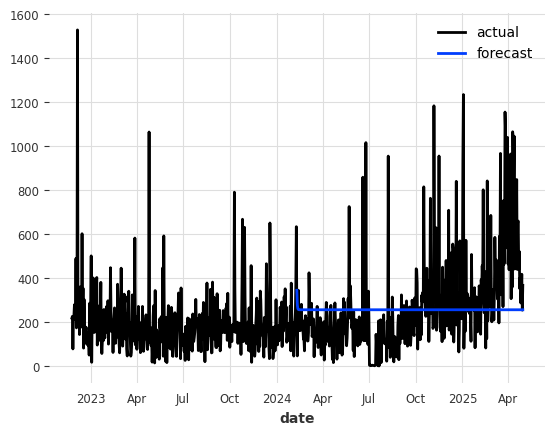

In [33]:
series.drop_before(visualizing).plot(label="actual")  # plot only last 5% of series
prediction_aarima.plot(label="forecast", low_quantile=0.05, high_quantile=0.95)
plt.legend()
plt.show()

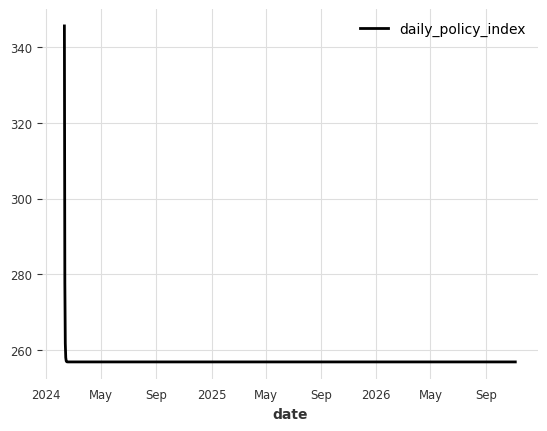

In [34]:
model_aarima.predict(1000).plot()
plt.show()

In [35]:
# add part about naive ma model here

In [36]:
from darts.models import (NaiveMean, NaiveMovingAverage, Prophet, AutoETS, AutoARIMA)

In [37]:
def backtest_models(series: TimeSeries, models: list=[AutoETS(), AutoARIMA(), Prophet(country_holidays="GB", suppress_stdout_stderror=True)], horizons: list=[1, 3, 7], points_to_test: int=100, verbose=True, retrain=True):
    backtest_results = dict()
    for horizon in sorted(horizons):
        backtests = [model.historical_forecasts(
            series,
            start=len(series) - points_to_test,
            forecast_horizon=horizon,
            verbose=verbose,
            retrain=retrain,
        ) for model in models]
        backtest_results[horizon] = {str(model): (backtests[i], mape(series, backtests[i])) for i, model in enumerate(models)}
    return backtest_results

In [38]:
def plot_backtest_results(series: TimeSeries, backtest_results: dict, points_to_test: int=100):
    for horizon, model in backtest_results.items():
        series.drop_before(len(series) - 2*points_to_test).plot(label='data')
        for model_name, (backtest, mape) in model.items():
            backtest.plot(lw=3, label=f'{model_name}, MAPE={mape:.2f}%')
        plt.title(f'Backtests with {horizon} {series.freq} forecast horizon')
        plt.legend()
        plt.show()

In [39]:
horizons = [1, 3, 7, 15, 30]

In [40]:
results = backtest_models(series, horizons=horizons)

historical forecasts:   0%|          | 0/100 [00:00<?, ?it/s]

historical forecasts:   0%|          | 0/100 [00:00<?, ?it/s]

KeyboardInterrupt: 

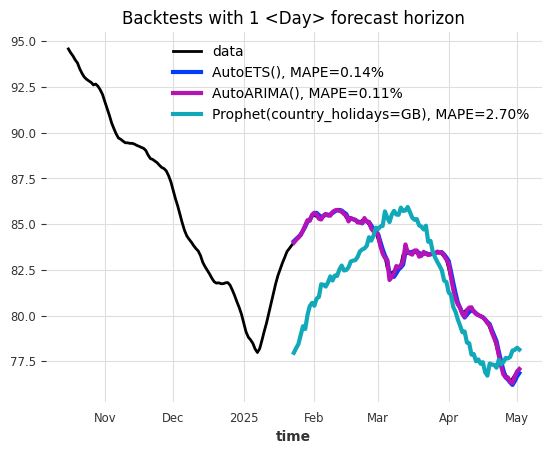

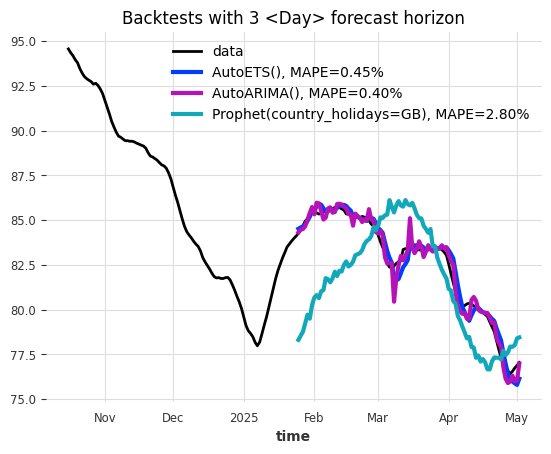

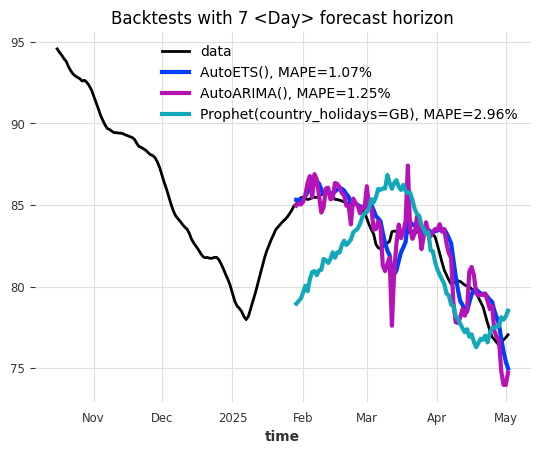

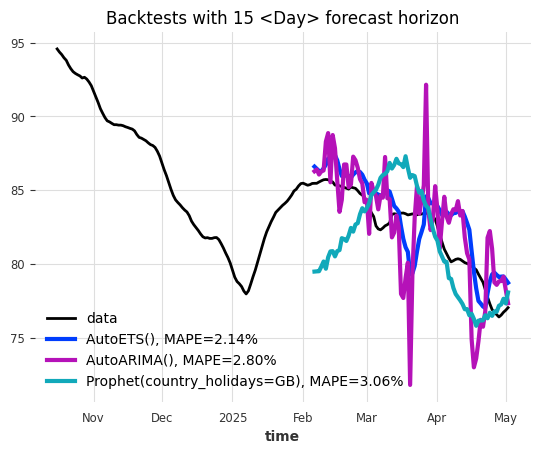

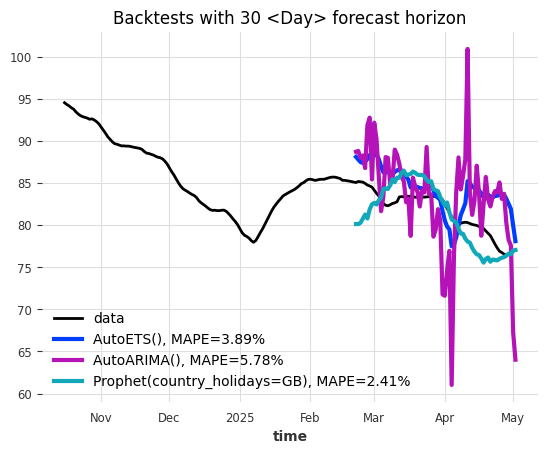

In [36]:
plot_backtest_results(series, results)

In [37]:
aarima_bic = AutoARIMA(trace=True, ic="bic")
aarima_bic = aarima_bic.fit(train)
aarima_aicc = AutoARIMA(trace=True, ic="aicc")
aarima_aicc = aarima_aicc.fit(train)


ARIMA(2,2,2)                   :inf

ARIMA(0,2,0)                   :-1576.0408951297502

ARIMA(1,2,0)                   :-1572.9572920349783

ARIMA(0,2,1)                   :-1572.4655852511605

ARIMA(1,2,1)                   :-1571.2018590318287
Now re-fitting the best model(s) without approximations...


ARIMA(0,2,0)                   :-1576.0408951297502

ARIMA(2,2,2)                   :inf

ARIMA(0,2,0)                   :-1581.544735877338

ARIMA(1,2,0)                   :-1583.962768462499

ARIMA(0,2,1)                   :-1583.4710616786813

ARIMA(2,2,0)                   :-1589.5474892514517

ARIMA(3,2,0)                   :-1595.6697334038981

ARIMA(4,2,0)                   :-1598.020444215008

ARIMA(5,2,0)                   :-1596.2323227853858

ARIMA(4,2,1)                   :-1658.5068596603742

ARIMA(3,2,1)                   :-1595.4252177759035

ARIMA(5,2,1)                   :-1642.5006327561073

ARIMA(4,2,2)                   :-1729.5931157459204

ARIMA(3,2,2)        

In [38]:
results = backtest_models(series, models=[aarima_bic, aarima_aicc], retrain=False, horizons=horizons)

historical forecasts:   0%|          | 0/100 [00:00<?, ?it/s]

historical forecasts:   0%|          | 0/100 [00:00<?, ?it/s]

historical forecasts:   0%|          | 0/98 [00:00<?, ?it/s]

historical forecasts:   0%|          | 0/98 [00:00<?, ?it/s]

historical forecasts:   0%|          | 0/94 [00:00<?, ?it/s]

historical forecasts:   0%|          | 0/94 [00:00<?, ?it/s]

historical forecasts:   0%|          | 0/86 [00:00<?, ?it/s]

historical forecasts:   0%|          | 0/86 [00:00<?, ?it/s]

historical forecasts:   0%|          | 0/71 [00:00<?, ?it/s]

historical forecasts:   0%|          | 0/71 [00:00<?, ?it/s]

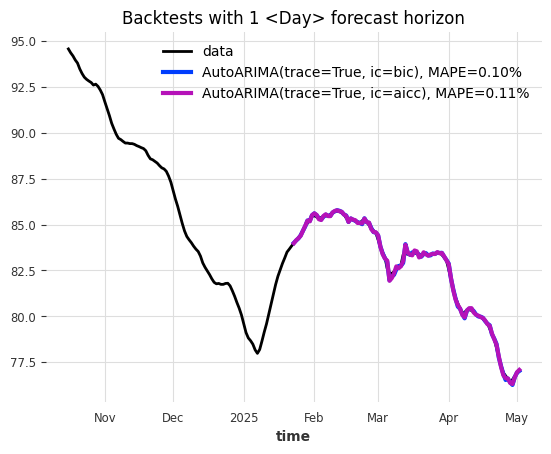

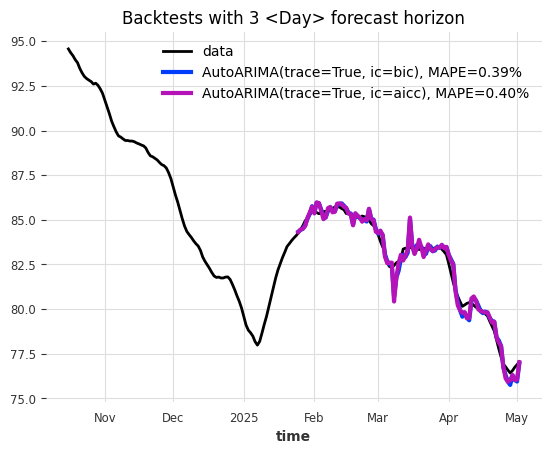

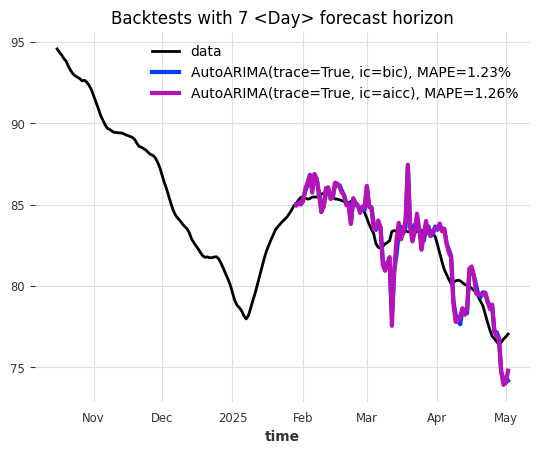

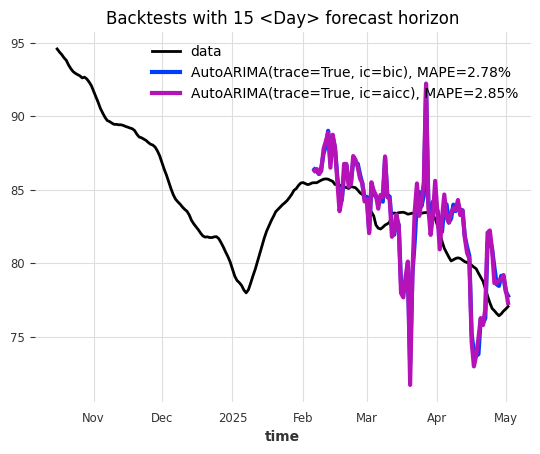

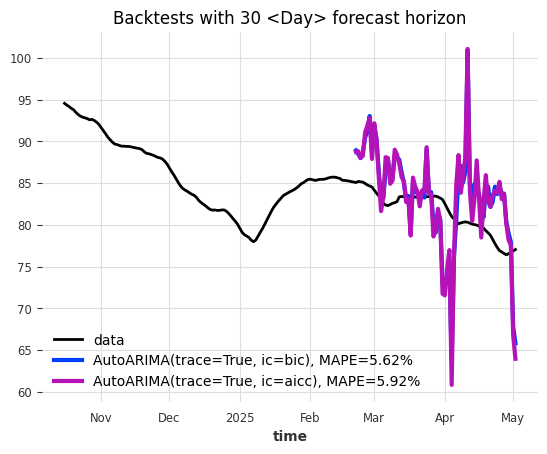

In [39]:
plot_backtest_results(series, results)

In [40]:
horizon = [7]

In [41]:
from darts.models import AutoETS

In [42]:
def ETS_optimize(trial: optuna.Trial, series: TimeSeries=series, single_horizon: list=horizon):
    params={
        "season_length": trial.suggest_int("ets_season_length", 1, 365),
        "model": trial.suggest_categorical("ets_e", ["M", "A", "Z"]) + trial.suggest_categorical("ets_t", ["N", "M", "A", "Z"]) + trial.suggest_categorical("ets_s", ["N", "M", "A", "Z"]),
    }
    
    model = AutoETS(**params)
    results = backtest_models(
        series, 
        models=[model], 
        horizons=single_horizon,
        points_to_test=50,
        verbose=False,
    )
    return results[single_horizon[0]][str(model)][1]

In [43]:
model_list = [
    "ETS",
    "AutoARIMA",
    "Prophet",
]
model_family = model_list[0]

In [44]:
# Create optuna study with defined function and storage
study = optuna.create_study(
    direction="minimize",
    storage=storage,
    study_name=f"{series_name}_{horizon[0]}_{model_family}_study",
    load_if_exists=True
)

[I 2025-05-11 23:06:43,250] Using an existing study with name 'Job_Postings_7_ETS_study' instead of creating a new one.


In [45]:
from darts.ad import KMeansScorer

scorer = KMeansScorer(k=2, window=5)
scorer.fit(train)
anom_score = scorer.score(val)

In [46]:
from darts.ad import QuantileDetector

detector = QuantileDetector(high_quantile=0.99)
detector.fit(scorer.score(train))
binary_anom = detector.detect(anom_score)

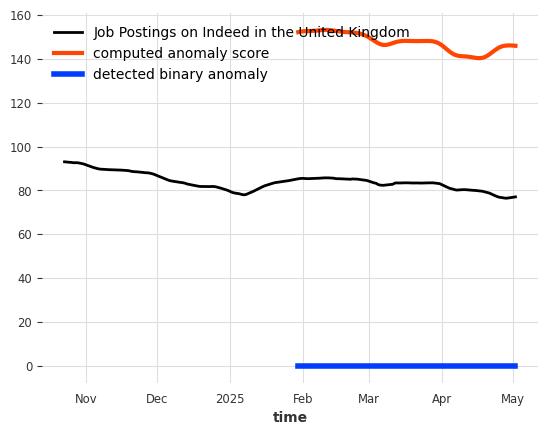

In [47]:
series.drop_before(visualizing).plot()
(anom_score + 1.5 * max(series.drop_before(visualizing))).plot(label="computed anomaly score", c="orangered", lw=3)
(binary_anom * .5 * max(series.drop_before(visualizing))).plot(label="detected binary anomaly", lw=4)
plt.show()